## Behavior cloning for end to end driver less cars


In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Lambda, Dropout
from keras.layers import Cropping2D
# from keras.utils.visualize_util import plot
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [2]:
import keras
print (keras.__version__)

import tensorflow as tf 
print (tf.__version__)

1.2.1
0.12.1


In [3]:
#from keras.utils.visualize_util import plot


## Load the data from simulator

In [4]:
project_directory = "/home/carnd/deeplearning/cnd/CarND-Behavioral-Cloning-P3/data/"
# project_directory = "/Users/kdalwani/cnd/CarND-Behavioral-Cloning-P3/data/sample_training_data/"
log_file_path = "driving_log.csv"

In [5]:
def get_log_files_pd(project_dir, log_file_path):
    lines = []
    log_pd = pd.read_csv(project_dir + log_file_path)
    return log_pd


In [6]:
log_pd = get_log_files_pd(project_directory, log_file_path)

In [7]:
log_pd.head()
print (log_pd.count())

center      8036
left        8036
right       8036
steering    8036
throttle    8036
brake       8036
speed       8036
dtype: int64


In [8]:
log_pd.head()


center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                   left  \
0  IMG/left_2016_12_01_13_30_48_287.jpg   
1  IMG/left_2016_12_01_13_30_48_404.jpg   
2  IMG/left_2016_12_01_13_31_12_937.jpg   
3  IMG/left_2016_12_01_13_31_13_037.jpg   
4  IMG/left_2016_12_01_13_31_13_177.jpg   

                                   right  steering  throttle  brake      speed  
0  IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0  22.148290  
1  IMG/right_2016_12_01_13_30_48_404.jpg       0.0       0.0    0.0  21.879630  
2  IMG/right_2016_12_01_13_31_12_937.jpg       0.0       0.0    0.0   1.453011  
3  IMG/right_2016_12_01_13_31_13_037.jpg       0.0       0.0    0.0   1.438419  
4  IMG/right_2016_12_01_13_31_13_177.jpg       0.0       0.0    0.0   1.418236

In [9]:
def load_training_data(log_pd, project_directory, add_flip_images=True, add_left_right_images=True, correction=0.2, 
      from_simulator=False):
    per_record = 1000
    X_train = []
    y_data = []
    if add_flip_images:
        print ("Adding flip images as well.")
    else:
        print ("Not adding flip images.")
    if add_left_right_images:
        print ("Adding left right images as well.")
    else:
        print ("Not adding left right images.")

    for index, row in log_pd.iterrows():
        if index % per_record == 0:
            print(".", end=" ")
        image_path = row['center']
        sterring_val = float(row['steering'])
        image_path = project_directory + image_path
        img = cv2.imread(image_path)    
        X_train.append(img)
        y_data.append(sterring_val)
        if add_flip_images:
            X_train.append(cv2.flip(img, 1))
            y_data.append(sterring_val * -1.0)
        if add_left_right_images:
            
            image_path_left = row['left']
            sterring_val_left = sterring_val + correction
            image_path_left = project_directory + row['left']
            img = cv2.imread(image_path_left)    
            X_train.append(img)
            y_data.append(sterring_val_left)

            image_path_right = row['right']
            sterring_val_right = sterring_val - correction
            image_path_right = project_directory + row['right']
            img = cv2.imread(image_path_right)    
            X_train.append(img)
            y_data.append(sterring_val_right)
        
    return X_train, y_data

In [10]:
def load_training_data_2(log_pd, project_directory, add_left_right_images=True, correction=0.2, 
      from_simulator=False):
    per_record = 1000
    X_train = []
    y_data = []
    if add_left_right_images:
        print ("Adding left right images as well.")
    else:
        print ("Not adding left right images.")

    for index, row in log_pd.iterrows():
        if index % per_record == 0:
            print(".", end=" ")
        image_path = row['center']
        sterring_val = float(row['steering'])
        image_path = project_directory + image_path
        img = cv2.imread(image_path)    
        X_train.append(img)
        y_data.append(sterring_val)
        if add_left_right_images:
            image_path_left = row['left']
            sterring_val_left = sterring_val + correction
            image_path_left = project_directory + row['left']
            img = cv2.imread(image_path_left)    
            X_train.append(img)
            y_data.append(sterring_val_left)

            image_path_right = row['right']
            sterring_val_right = sterring_val - correction
            image_path_right = project_directory + row['right']
            img = cv2.imread(image_path_right)    
            X_train.append(img)
            y_data.append(sterring_val_right)

    X_train_flip, y_data_flip = add_flip_images(X_train, y_data)    
    
    X_train = np.concatenate([X_train, X_train_flip])
    y_data = np.concatenate([y_data, y_data_flip])
    
    return X_train, y_data

def add_flip_images(X_data, y_data, sample_zero_angle_flip_prob=1.0, sample_non_zero_angle_flip_prob=1.0):
    per_record = 1000
    X_train_flip = []
    y_data_flip = []
    for index in range(len(X_data)):
        img = X_data[index]
        sterring_val = y_data[index]
        # don't add in case zero sterring angle and rand() prob. less than sample
        if ((sterring_val == 0.0 and np.random.rand() <= sample_zero_angle_flip_prob) 
            or (sterring_val != 0.0 and np.random.rand() <= sample_non_zero_angle_flip_prob)):
            X_train_flip.append(cv2.flip(img, 1))
            y_data_flip.append(sterring_val * -1.0)
            
    return X_train_flip, y_data_flip
    

## Load images using Generator

In [11]:
import os
import csv


from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(log_pd, test_size=0.2)

import cv2
import numpy as np
import sklearn

batch_size = 24
factor_image = 6
def generator(log_pd, project_directory, add_left_right_images=True, add_flipped_images=True, correction=0.2, 
      from_simulator=False, batch_size=32, sample_zero_angle_prob = 1.0, sample_zero_angle_flip_prob = 1.0,
             sample_left_right_zero_angle_correction=1.0):
    samples = log_pd.as_matrix()
    num_samples = len(samples)
    per_record = 1000
    X_train = []
    y_data = []
    print ("\nAdd left image: %s, flip image:%s, \n\tsample zero anngle prob:%.2f, sample zero angle flip:%.2f, sample_left_right_zero_angle_correction:%.2f" % 
          (add_left_right_images, add_flipped_images, sample_zero_angle_prob, sample_zero_angle_flip_prob, 
              sample_left_right_zero_angle_correction))
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            if (offset/batch_size % 3 == 0):
                print(".", end=" ")

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                image_path = batch_sample[0]
                sterring_val = float(batch_sample[3])
                image_path = project_directory + image_path
                img = cv2.imread(image_path)   
                if sterring_val != 0.0 or np.random.rand() <= sample_zero_angle_prob:
                    images.append(img)
                    angles.append(sterring_val)
                if (add_left_right_images and 
                    (sterring_val != 0.0 or np.random.rand() <= sample_left_right_zero_angle_correction)):
                    sterring_val_left = sterring_val + correction
                    image_path_left = project_directory + batch_sample[1]
                    img = cv2.imread(image_path_left)    
                    images.append(img)
                    angles.append(sterring_val_left)

                    sterring_val_right = sterring_val - correction
                    image_path_right = project_directory +  batch_sample[2]
                    img = cv2.imread(image_path_right)    
                    images.append(img)
                    angles.append(sterring_val_right)

            X_train = images
            y_train = angles

            if add_flipped_images:
                images_flip, images_y_data_flip = add_flip_images(images, angles,
                    sample_zero_angle_flip_prob, 1.0
                )  
                X_train = np.concatenate([X_train, images_flip])
                y_train = np.concatenate([y_train, images_y_data_flip])
            yield sklearn.utils.shuffle(X_train, y_train)

In [12]:
np.random.rand()

0.4578646912729698

In [13]:
train_generator = generator(train_samples, project_directory, batch_size=batch_size)
validation_generator = generator(validation_samples, project_directory, batch_size=batch_size)
len_train_samples = len(train_samples) * factor_image
len_valid_samples = len(validation_samples) * factor_image

In [14]:
train_gen_sample = next(train_generator)
valid_gen_sample = next(validation_generator)


Add left image: True, flip image:True, 
	sample zero anngle prob:1.00, sample zero angle flip:1.00, sample_left_right_zero_angle_correction:1.00
. 
Add left image: True, flip image:True, 
	sample zero anngle prob:1.00, sample zero angle flip:1.00, sample_left_right_zero_angle_correction:1.00
. 

In [15]:
print (len_train_samples)
print (len_valid_samples)

38568
9648


# Run generator using diff. sampling strategies and plot their sterring angles

In [17]:
import itertools
# run for one epoch
batch_size = 24
len_train_samples  = len (train_samples)
train_generator_all = generator(train_samples, project_directory, batch_size=batch_size)
train_generator_all_no_flip_no_left_right = generator(train_samples, project_directory, add_left_right_images=False, add_flipped_images=False, batch_size=batch_size)
train_generator_all_sample_non_zero_flip = generator(train_samples, project_directory, batch_size=batch_size, sample_zero_angle_flip_prob=0.1)
train_generator_all_sample_zero_sample_zero_flip = generator(train_samples, project_directory, batch_size=batch_size, 
                                                             sample_zero_angle_flip_prob=0.1, sample_zero_angle_prob=0.2)
train_generator_all_sample_zero_sample_zero_flip_sample_sample_left_right = generator(train_samples, project_directory, batch_size=batch_size, 
                                                             sample_zero_angle_flip_prob=0.1, sample_zero_angle_prob=0.2, 
                                                             sample_left_right_zero_angle_correction=0.2)

y_train_all = []
y_train_no_flip_no_left_right = []
y_train_generator_all_sample_non_zero_flip = []
y_train_all_sample_zero_sample_zero_flip = []
y_train_generator_all_sample_zero_sample_zero_flip_sample_sample_left_right = []
for index in range ((int)(len_train_samples/batch_size)):
    y_train_all.append(next(train_generator_all)[1])
    y_train_no_flip_no_left_right.append(next(train_generator_all_no_flip_no_left_right)[1])    
    y_train_generator_all_sample_non_zero_flip.append(next(train_generator_all_sample_non_zero_flip)[1])    
    y_train_all_sample_zero_sample_zero_flip.append(next(train_generator_all_sample_zero_sample_zero_flip)[1])    
    y_train_generator_all_sample_zero_sample_zero_flip_sample_sample_left_right.append(next(train_generator_all_sample_zero_sample_zero_flip_sample_sample_left_right)[1])    
    
y_pd = pd.Series(list(itertools.chain.from_iterable(y_train_all)))
y_no_flip_left_right = pd.Series(list(itertools.chain.from_iterable(y_train_no_flip_no_left_right)))
y_pd_sample_non_zero_flip = pd.Series(list(itertools.chain.from_iterable(y_train_generator_all_sample_non_zero_flip)))
y_pd_y_train_all_sample_zero_sample_zero_flip = pd.Series(list(itertools.chain.from_iterable(y_train_all_sample_zero_sample_zero_flip)))
y_pd_sample_zero_sample_zero_flip_sample_sample_left_right = pd.Series(list(itertools.chain.from_iterable(y_train_generator_all_sample_zero_sample_zero_flip_sample_sample_left_right)))




Add left image: True, flip image:True, 
	sample zero anngle prob:1.00, sample zero angle flip:1.00, sample_left_right_zero_angle_correction:1.00
. 
Add left image: False, flip image:False, 
	sample zero anngle prob:1.00, sample zero angle flip:1.00, sample_left_right_zero_angle_correction:1.00
. 
Add left image: True, flip image:True, 
	sample zero anngle prob:1.00, sample zero angle flip:0.10, sample_left_right_zero_angle_correction:1.00
. 
Add left image: True, flip image:True, 
	sample zero anngle prob:0.20, sample zero angle flip:0.10, sample_left_right_zero_angle_correction:1.00
. 
Add left image: True, flip image:True, 
	sample zero anngle prob:0.20, sample zero angle flip:0.10, sample_left_right_zero_angle_correction:0.20
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Size y_pd:38448
Size y_no_flip_left_right:6408
Size y_pd_sample_non_zero_flip:35313
Size y_pd_y_train_all_sample_zero_sample_zero_flip:32297
Size y_pd_sample_zero_sample_zero_flip_sample_sample_left_right:21152


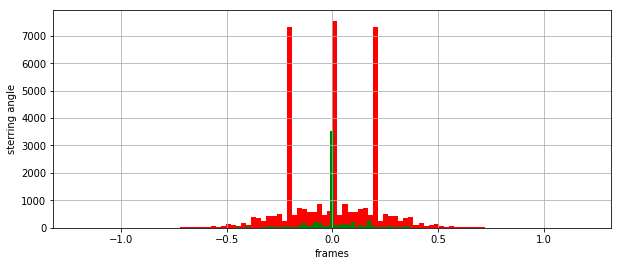

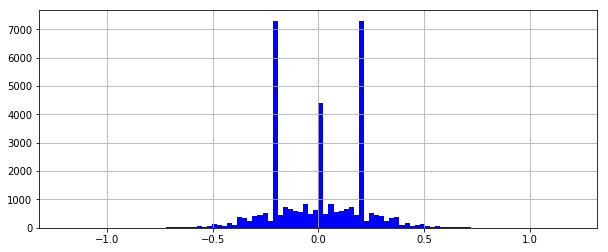

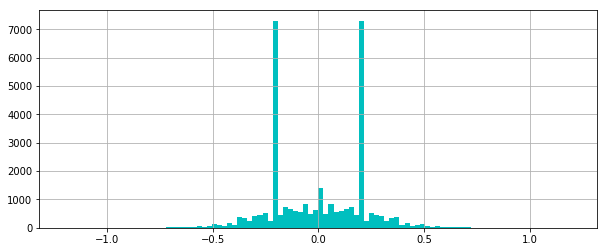

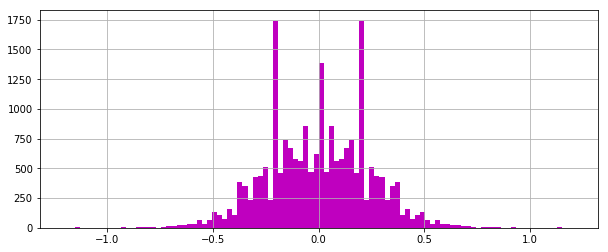

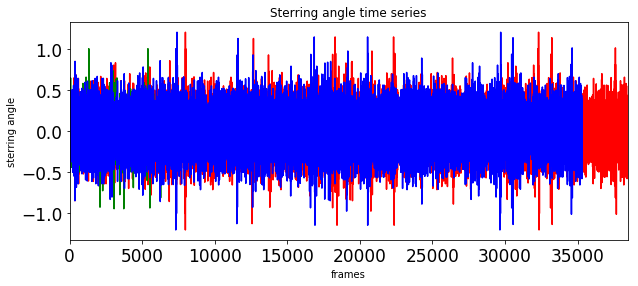

In [18]:
print ("Size y_pd:" + str(len(y_pd)))
print ("Size y_no_flip_left_right:" + str(len(y_no_flip_left_right)))
print ("Size y_pd_sample_non_zero_flip:" + str(len(y_pd_sample_non_zero_flip)))
print ("Size y_pd_y_train_all_sample_zero_sample_zero_flip:" + str(len(y_pd_y_train_all_sample_zero_sample_zero_flip)))
print ("Size y_pd_sample_zero_sample_zero_flip_sample_sample_left_right:" + str(len(y_pd_sample_zero_sample_zero_flip_sample_sample_left_right)))

y_pd_sample_zero_sample_zero_flip_sample_sample_left_right
plt.figure(figsize=(10,4))
plt.xlabel("frames")
plt.ylabel("sterring angle")

y_pd.hist(bins=100, color='r')
y_no_flip_left_right.hist(bins=100, color='g')
plt.figure(figsize=(10,4))
y_pd_sample_non_zero_flip.hist(bins=100, color='b')
plt.figure(figsize=(10,4))
y_pd_y_train_all_sample_zero_sample_zero_flip.hist(bins=100, color='c')
plt.figure(figsize=(10,4))
y_pd_sample_zero_sample_zero_flip_sample_sample_left_right.hist(bins=100, color='m')


plt.figure(figsize=(10,4))
y_pd.plot(title="Sterring angle time series", fontsize=17, figsize=(10,4), color='r')
y_no_flip_left_right.plot(title="Sterring angle time series", fontsize=17, figsize=(10,4), color='g')
y_pd_sample_non_zero_flip.plot(title="Sterring angle time series", fontsize=17, figsize=(10,4), color='b')
plt.xlabel("frames")
plt.ylabel("sterring angle")

# the flipped or non-flipped graph is skewed for 

## Pick the best generator as per the graph above

In [16]:
train_generator = generator(train_samples, project_directory, batch_size=batch_size, 
 sample_zero_angle_flip_prob=0.1, sample_zero_angle_prob=0.2, 
 sample_left_right_zero_angle_correction=0.2
)

validation_generator = generator(validation_samples, project_directory, batch_size=batch_size)
len_train_samples = len(train_samples) * factor_image
len_valid_samples = len(validation_samples) * factor_image
train_gen_sample = next(train_generator)
valid_gen_sample = next(validation_generator)


Add left image: True, flip image:True, 
	sample zero anngle prob:0.20, sample zero angle flip:0.10, sample_left_right_zero_angle_correction:0.20
. 
Add left image: True, flip image:True, 
	sample zero anngle prob:1.00, sample zero angle flip:1.00, sample_left_right_zero_angle_correction:1.00
. 

In [17]:
# X_images, steerings = load_training_data(log_pd, project_directory)
# #print ("done")

In [18]:
#print ("X train length:", len(X_images))
#print ("Y train length:", len(steerings))

In [19]:
def plot_sample_train_data(X_data, y_data, images_to_plot=20, images_per_row=4):
    total_rows = (np.ceil)(images_to_plot / images_per_row)
    idx = np.random.choice(range(0, len(X_data)), images_to_plot, replace=False)
    f, axes = plt.subplots(figsize=(25,25))
    for i, index in enumerate(idx):
        plt.subplot(total_rows, images_per_row, i+1)
        plt.axis("off")
        plt.imshow(X_data[index].astype('uint8'))
        plt.title("{:.3f}".format(y_data[index]))
    # plot the mean image    
    plt.imshow(np.mean(X_data, axis=0).astype("uint8"))
    plt.title("Mean image: {:.3f}".format(np.mean(y_data)))
    plt.show()
    


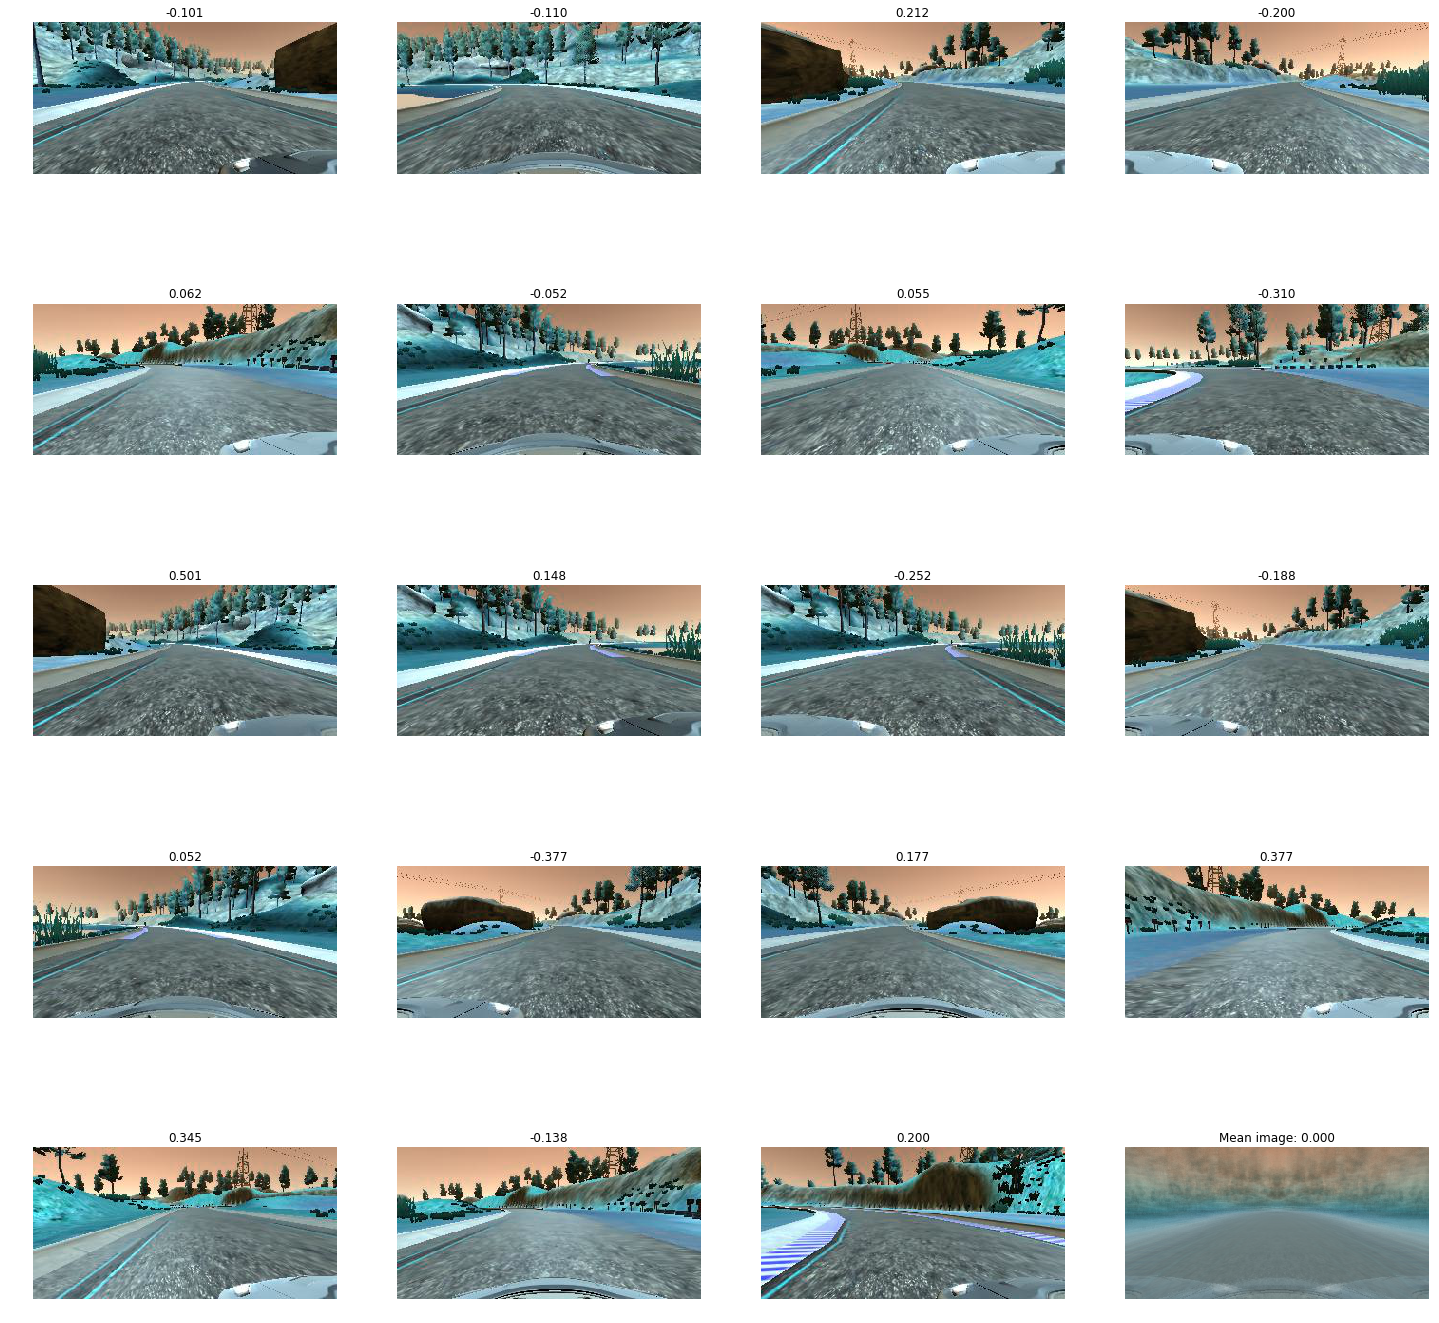

In [20]:
plot_sample_train_data(train_gen_sample[0], train_gen_sample[1], images_to_plot=20)

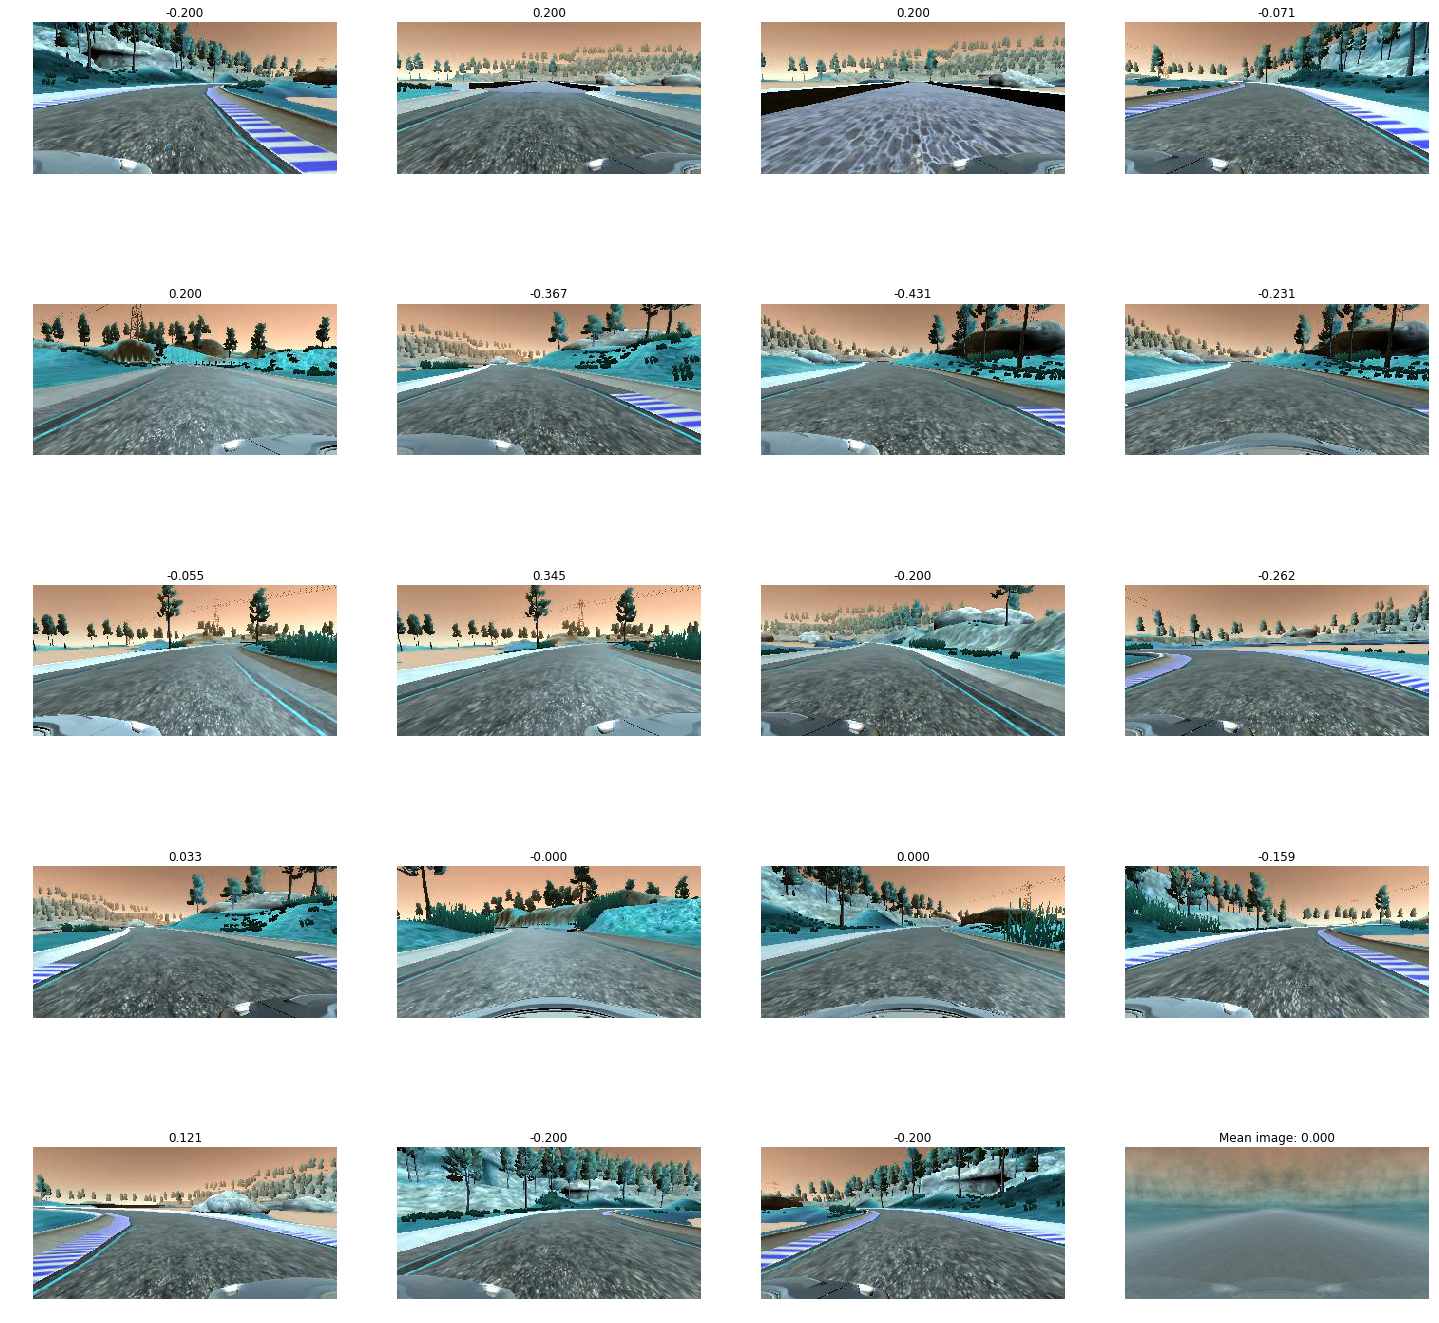

In [24]:
plot_sample_train_data(valid_gen_sample[0], valid_gen_sample[1], images_to_plot=20)

## Plot mean image

In [ ]:
# plt.imshow(np.mean(X_images, axis=0).astype("uint8"))
# plt.title("Mean image: {:.3f}".format(np.mean(steerings)))
# plt.show()


In [21]:
# do the training 

#X_train, y_train = np.array(X_images[:200]), np.array(steerings[:200])
print (train_gen_sample[0][0].shape)
print (len(train_gen_sample[0]))

(160, 320, 3)
70


In [22]:
y_pd = pd.Series(train_gen_sample[1])
y_pd.describe()

count    7.000000e+01
mean     3.965082e-18
std      2.187054e-01
min     -5.009732e-01
25%     -1.693889e-01
50%      0.000000e+00
75%      1.693889e-01
max      5.009732e-01
dtype: float64

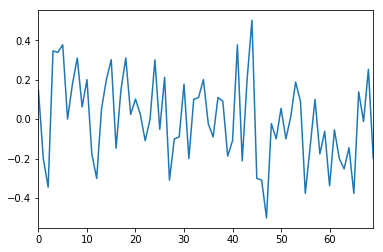

In [23]:
y_pd.plot()

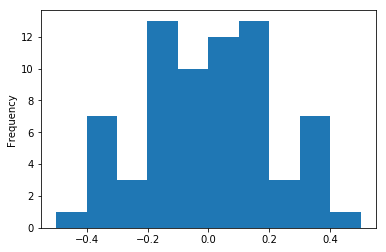

In [24]:
y_pd.plot(kind='hist')

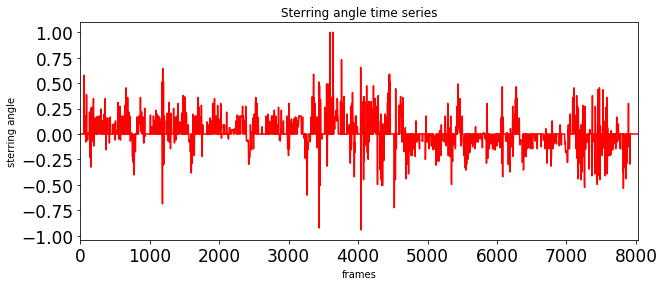

In [25]:
log_pd.steering.plot(title="Sterring angle time series", fontsize=17, figsize=(10,4), color='r')
plt.xlabel("frames")
plt.ylabel("sterring angle")


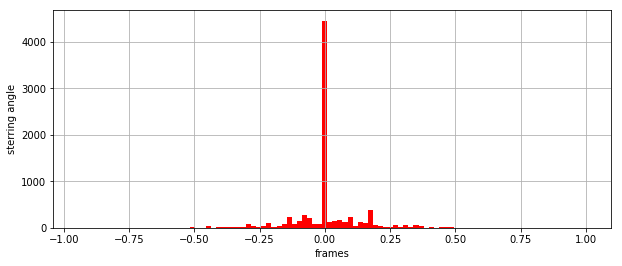

In [26]:
plt.figure(figsize=(10,4))
log_pd.steering.hist(bins=100, color='r')
plt.xlabel("frames")
plt.ylabel("sterring angle")


In [27]:
def plot_model_history(histroy):

    # summarize history for loss
    plt.plot(histroy.history['loss'])
    plt.plot(histroy.history['val_loss'])
    plt.legend(['train', 'val'], loc='upper left')

    # summarize history for loss
    plt.title('model loss Train vs Validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [39]:
import keras

class ModelSaveEveryEpoch(keras.callbacks.Callback):
    filepath="every_epoch:{epoch:02d}.model"
    
    def __init__(self, key):
        self.filepath = key + "_" + self.filepath

    def on_epoch_end(self, epoch, logs={}):
        if epoch %3 == 0:
            file_path = self.filepath.format(epoch=2)
            print ("Saving the model at epoch:" + str(file_path))
            self.model.save(file_path)




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 160, 320, 3)   0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
cropping2d_6 (Cropping2D)        (None, 90, 320, 3)    0           lambda_6[0][0]                   
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 86, 316, 24)   1824        cropping2d_6[0][0]               
____________________________________________________________________________________________________
maxpooling2d_26 (MaxPooling2D)   (None, 43, 158, 24)   0           convolution2d_26[0][0]           
___________________________________________________________________________________________

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


. Saving the model at epoch:test_nvdia_model_epoch_10_dropout_0.3_every_epoch:02.model
55/40 [=========================================] - 2s - loss: 0.1289 - val_loss: 0.0329
Epoch 2/10
84/40 [===============================================================] - 0s - loss: 0.0495 - val_loss: 0.0393
Epoch 3/10
87/40 [=================================================================] - 0s - loss: 0.0571 - val_loss: 0.0447
Epoch 4/10
. Saving the model at epoch:test_nvdia_model_epoch_10_dropout_0.3_every_epoch:02.model
118/40 [========================================================================================] - 1s - loss: 0.0505 - val_loss: 0.0385
Epoch 5/10
84/40 [===============================================================] - 0s - loss: 0.0412 - val_loss: 0.0433
Epoch 6/10
83/40 [==============================================================] - 0s - loss: 0.0540 - val_loss: 0.0444
Epoch 7/10
. Saving the model at epoch:test_nvdia_model_epoch_10_dropout_0.3_every_epoch:02.model
76

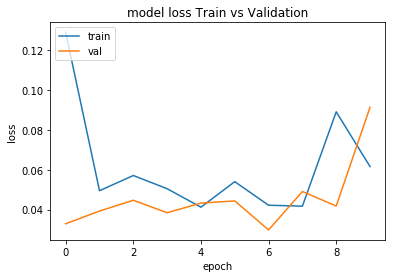

(<keras.models.Sequential at 0x7f60243ee208>,
 <keras.callbacks.History at 0x7f600759ad68>)

In [40]:
width, height, depth = train_gen_sample[0][0].shape
num_pixels = (width * height* depth)
# from keras.utils import plot_model
# from keras.utils.visualize_util import plot
# model_path = "baseline.h5"
from IPython.display import SVG
# from keras.utils.visualize_util import model_to_dot

def run_model(model, training_data, target_data, model_path, epochs = 10):
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(training_data, target_data, validation_split=0.2,
                        shuffle=True, nb_epoch=epochs, verbose=1)
    print ("Plotting the model architecture:")
    plot(model, to_file=model_path + '_architecture.png', show_shapes=True)    

    SVG(model_to_dot(model).create(prog='dot', format='svg'))    
    model_path = model_path + ".model"
    print ("saving the model file:" + model_path)
    model.save(model_path)
    plot_model_history(history)
    return model, history

def run_baseline_model(training_data, target_data, epochs = 10):
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (width, height, depth)))
    model.add(Flatten())
    model.add(Dense(1))
    
    return run_model(model, training_data, target_data, "baseline_model", epochs=epochs)

from keras.layers.convolutional import Conv2D, MaxPooling2D

def run_lenet_model(training_data, target_data, dropout=0.5, epochs = 10, model_prefix=""):
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (width, height, depth)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))    

    # layer 1 Conv. + Relu + Max Pool
    model.add(Conv2D(6, kernel_size=(5, 5),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Dropout(dropout))

    
    # layer 2 Conv. + Relu + Max Pool
    model.add(Conv2D(16, kernel_size=(5, 5),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))    
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model_key = "epoch_" + str(epochs) + "_dropout_" + str(dropout)
    
    return run_model(model, training_data, target_data, model_prefix + "_lenet_model_" + model_key , epochs=epochs)

def create_nvdia_model(dropout=0.5):
    
#     https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
#     https://github.com/mxbi/carnd-behavioural-cloning/blob/master/model.py#L26
#         https://discussions.udacity.com/t/help-stuck-just-cant-get-a-full-lap-on-the-track/240144/11
#         https://discussions.udacity.com/t/different-car-behavior-to-each-training-and-tuning-process/240110/13
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (width, height, depth)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))    

    # layer 1 Conv. + Relu + Max Pool
    model.add(Conv2D(24, 5, 5,
                        subsample=(1, 1), border_mode='valid',    
                        activation='relu', bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Dropout(dropout))

    
    # layer 2 Conv. + Relu + Max Pool
    model.add(Conv2D(36, 5, 5,
                        subsample=(1, 1), border_mode='valid',    
                        activation='relu', bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Dropout(dropout))

    # layer 3 Conv. + Relu + Max Pool
    model.add(Conv2D(48, 5, 5,
                        subsample=(1, 1), border_mode='valid',    
                        activation='relu', bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Dropout(dropout))

    # layer 4 Conv. + Relu + Max Pool
    model.add(Conv2D(64, 3, 3,
                        subsample=(1, 1), border_mode='valid',    
                        activation='relu', bias=True))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))    
    model.add(Dropout(dropout))

    # layer 5 Conv. + Relu + Max Pool
    model.add(Conv2D(64, 3, 3,
                        subsample=(1, 1), border_mode='valid',    
                        activation='relu', bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))    
    model.add(Dropout(dropout))
    
    # 3 FC layers 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model


def train_run_nvida_model(training_data, target_data, dropout=0.5, epochs = 10, model_prefix=""):
    nvdia_model = create_nvdia_model(dropout=dropout)

    model_key = "epoch_" + str(epochs) + "_dropout_" + str(dropout)
    model_prefix = model_prefix + "_nvdia_model_" + model_key
    
    return run_model(nvdia_model, training_data, target_data, model_prefix, epochs=epochs)


def run_model_with_gen(model, train_generator, validation_generator, len_train_samples, len_valid_samples,
                       model_path, epochs = 10):
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    save_model_callback = ModelSaveEveryEpoch(model_path)
    history = model.fit_generator(train_generator, samples_per_epoch = len_train_samples, 
                        validation_data=validation_generator, nb_val_samples=len_valid_samples, 
                        nb_epoch=epochs, verbose=1, callbacks=[save_model_callback])
#     print ("Plotting the model architecture:")
#     plot_model(model, to_file=model_path + '_architecture.png', show_shapes=True)    

#     SVG(model_to_dot(model).create(prog='dot', format='svg'))    
    model_path = model_path + ".model"
    print ("saving the model file:" + model_path)
    model.save(model_path)
    plot_model_history(history)
    return model, history

def train_run_nvida_model_with_gen(train_generator, validation_generator, len_train_samples,
                                   len_valid_samples, dropout=0.5, epochs = 10, model_prefix=""):
    nvdia_model = create_nvdia_model(dropout=dropout)

    model_key = "epoch_" + str(epochs) + "_dropout_" + str(dropout)
    model_prefix = model_prefix + "_nvdia_model_" + model_key
    
    return run_model_with_gen(nvdia_model, train_generator, validation_generator, 
                                len_train_samples, len_valid_samples,
                                model_prefix, epochs=epochs)
train_run_nvida_model_with_gen(train_generator, validation_generator, 40, 40,
                               dropout=0.3, model_prefix='test', epochs=10)
#SVG(model_to_dot(create_nvdia_model(dropout=0.5), show_shapes=True).create(prog='dot', format='svg'))

Epoch 1/10
38568/38568 [==============================] - 219s - loss: 0.0273 - val_loss: 0.0199. . . . . . . . . . . . 

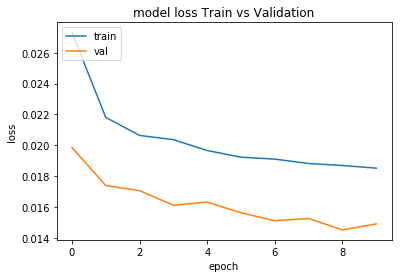

(<keras.models.Sequential at 0x7f2b40f0b198>,
 <keras.callbacks.History at 0x7f2b3df58a58>)

In [79]:
train_run_nvida_model_with_gen(train_generator, validation_generator, len_train_samples, len_valid_samples,
                               dropout=0.3, model_prefix='crop_with_gen_all_image', epochs=10)


Epoch 1/3
38529/38568 [============================>.] - ETA: 0s - loss: 0.0315   . . . . . 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


38588/38568 [==============================] - 377s - loss: 0.0314 - val_loss: 0.0208
Epoch 2/3
38650/38568 [==============================] - 240s - loss: 0.0250 - val_loss: 0.0186. . . . 

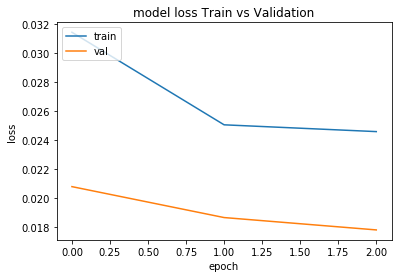

(<keras.models.Sequential at 0x7f60761fe978>,
 <keras.callbacks.History at 0x7f6075ddcbe0>)

In [29]:
train_run_nvida_model_with_gen(train_generator, validation_generator, len_train_samples, len_valid_samples,
                               dropout=0.3, model_prefix='sample_gen_crop_with_gen_all_image', epochs=3)


In [ ]:
train_run_nvida_model_with_gen(train_generator, validation_generator, len_train_samples, len_valid_samples,
                               dropout=0.3, model_prefix='sample_gen_crop_with_gen_all_image', epochs=10)


Epoch 1/10
38503/38568 [============================>.] - ETA: 0s - loss: 0.0315  . . . . 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


38596/38568 [==============================] - 239s - loss: 0.0315 - val_loss: 0.0192
Epoch 2/10
38572/38568 [==============================] - 233s - loss: 0.0254 - val_loss: 0.0190. . . . 

In [ ]:
# baseline_model, baseline_histroy = run_baseline_model(X_train, y_train, epochs=10)

In [ ]:
lenet_model, lenet_history = run_lenet_model(X_train, y_train, epochs=10)

In [ ]:
lenet_model_epoch10, lenet_history = run_lenet_model(X_train, y_train, epochs=10)
lenet_model_epoch5, lenet_history = run_lenet_model(X_train, y_train, epochs=5)


In [ ]:
## Lenet With Cropping
lenet_model_epoch10, lenet_history = run_lenet_model(X_train, y_train, epochs=10, model_prefix="_crop_")
lenet_model_epoch5, lenet_history = run_lenet_model(X_train, y_train, epochs=5,   model_prefix="_crop_")


### Nvida architecture run

In [ ]:
# nvida_mode_10, _ = train_run_nvida_model(X_train, y_train, epochs=10, model_prefix="_crop_left_right_flip_")
# nvida_mode, _ = train_run_nvida_model(X_train, y_train, epochs=5, model_prefix="_crop_left_right_flip_")


# Nvida with Generators

In [52]:
train_run_nvida_model_with_gen(train_generator, validation_generator, len_train_samples, len_valid_samples,
                               model_prefix='crop_with_gen', epochs=1)

TypeError: __init__() missing 2 required positional arguments: 'nb_row' and 'nb_col'

In [ ]:
SVG(model_to_dot(create_nvdia_model(dropout=0.5), show_shapes=True).create(prog='dot', format='svg'))
#SVG(model_to_dot(nvida_mode, show_shapes=True).create(prog='dot', format='svg'))



## Baseline model

In [ ]:
#SVG(model_to_dot(baseline_model, show_shapes=True).create(prog='dot', format='svg'))

## LeNet model

In [ ]:
SVG(model_to_dot(lenet_model, show_shapes=True).create(prog='dot', format='svg'))

## Model with Lambda layer

## Log of attemps

- All sample images 
    - Basic architecture of flat + Dense
    - Basic architectire of flat + 100 Dense + Dense
- 2) All sample images + flip images
- (3)=== (2) + lLambda(lambda x: (x/255.0) - 0.5
- Flip images with LeNet
- Multiple Cameras https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/46a70500-493e-4057-a78e-b3075933709d/concepts/2cd424ad-a661-4754-8421-aec8cb018005
- Cropping Image
- NVida architecture
- Multiple camera CV the correction
- Generator Python 

### To do next


- More data collection